In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
from scipy.interpolate import interp1d, interp2d

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sea

from astropy.cosmology import Planck13 as cosmo
from astropy import units as u
from astropy.io import fits
from astropy.table import Table

from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_exam import Gen_spec

import fsps
from grizli import multifit
from grizli import model
from grizli.utils import SpectrumTemplate


import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [22]:
def Gen_initial_MB(field, gid):
    # get beam list
    fl = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/*{}*/*{}*'.format(field,gid))
    
    # sort beams
    sz = []
    for f in fl:
        sz.append(os.path.getsize(f))

    fl = np.array(fl)[np.argsort(sz)]

    # remove repeats
    nlist = []
    blist = []
    for f in fl:
        mb = multifit.MultiBeam(f,**args)
        for bm in mb.beams:
            if bm.grism.parent_file not in nlist:
                nlist.append(bm.grism.parent_file)
                blist.append(bm)
    
    #make the mb
    mb = multifit.MultiBeam(blist,**args)

    for b in mb.beams:
        if hasattr(b, 'xp'):
            delattr(b, 'xp')
    mb.initialize_masked_arrays()
    
    return mb

def Plot_beams(mb):
    plt.figure(figsize=[12,12])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    for bm in mb.beams:
        xspec, yspec, yerr = bm.beam.optimal_extract(bm.grism.data['SCI'] - bm.contam,ivar = bm.ivar)

        flat_model = bm.flat_flam.reshape(bm.beam.sh_beam)
        xspecm, yspecm, yerrm = bm.beam.optimal_extract(flat_model)

        if bm.grism.filter == 'G102':
            IDX = [U for U in range(len(xspec)) if 8000 < xspec[U] < 11300]
            ax1.plot(xspec[IDX],yspec[IDX]/yspecm[IDX], color = 'b')
        else:
            IDX = [U for U in range(len(xspec)) if 11200 < xspec[U] < 16500]
            ax2.plot(xspec[IDX],yspec[IDX]/yspecm[IDX], color = 'r') 

    fig = mb.oned_figure(show_beams=False)
    
    
def Beam_cleanups(select = False, clip = False, omit = False, B_condition, R_condition):

    if clip or omit:
        select = True

    BEAM_exempt =[]
    ids = 0
    omitspec = []
    clipspec = []

    ### selection for bad beams
    for bm in mb.beams:
        xspec, yspec, yerr = bm.beam.optimal_extract(bm.grism.data['SCI'] - bm.contam,ivar = bm.ivar)
        flat_model = bm.flat_flam.reshape(bm.beam.sh_beam)
        xspecm, yspecm, yerrm = bm.beam.optimal_extract(flat_model)
        
        if select:
            #condition of bad beams
            bex = False

            for i in range(len(xspec)):
    #             if (bm.grism.filter == 'G102' and 11000< xspec[i] < 11300) and (yspec[i]/yspecm[i]) > 0.2E-17:
    #                 bex = True
    # #                 clipspec.append(0)
    # #                 omitspec.append(1)        
    #                 break


                if (bm.grism.filter == 'G141' and 13000< xspec[i] < 14000) and ((yspec[i]/yspecm[i]) > 2.5E-18):
                    bex = True
    #                 clipspec.append(0)
    #                 omitspec.append(1)        
                    break

    #             if bm.grism.filter == 'G141':
    #                 bex = True
    #                 clipspec.append(1)
    #                 omitspec.append(0)
    #                 break
            if bex:
                BEAM_exempt.append(bm.grism.parent_file)


### set up selection settings
if clip and not omit:
    clipspec = np.ones(len(BEAM_exempt))
    omitspec = np.zeros(len(BEAM_exempt))
if omit and not clip:
    omitspec = np.ones(len(BEAM_exempt))
    clipspec = np.zeros(len(BEAM_exempt))
if omit and clip:
    pass
    ###selection tool TBD

### if beams are to be clipped

multclip = False
if clip:    
    Clims =[[13000, 13500]]
else:
    clip_lims = []
    clipspec = np.zeros(len(BEAM_exempt))

if multclip:
    pass
    ###selection tool TBD
else:
    clip_lims = [Clims for U in BEAM_exempt]

if clip:
    idc = 0
    for bm in mb.beams:
        if bm.grism.parent_file in BEAM_exempt:
            xspec, yspec, yerr = bm.beam.optimal_extract(bm.grism.data['SCI'] - bm.contam,ivar = bm.ivar) 
            for lms in clip_lims[idc]:
                if clipspec[idc] == 1:
                    for i in range(len(xspec)):
                        if lms[0] < xspec[i]< lms[1]:
                            bm.grism.data['SCI'].T[i] = np.zeros_like(bm.grism.data['SCI'].T[i])
                            bm.grism.data['ERR'].T[i] = np.ones_like(bm.grism.data['ERR'].T[i])*1000
            idc+=1 

### if beams are to be omitted
if omit:
    ido = 0
    IDB = []
    for i in range(len(mb.beams)):
        if mb.beams[i].grism.parent_file in BEAM_exempt:
            if omitspec[ido] == 1:
                IDB.append(i) 
            ido += 1
                   
    BEAMS = []
    
    for i in range(len(mb.beams)):
        if i not in IDB:
            BEAMS.append(mb.beams[i])

else:
    BEAMS = mb.beams
    omitspec = np.zeros(len(BEAM_exempt))

In [2]:
GND_all = pd.read_pickle('../dataframes/galaxy_frames/GND_CLEAR.pkl')
GSD_all = pd.read_pickle('../dataframes/galaxy_frames/GSD_CLEAR.pkl')

In [16]:
temps = {}
for k in args['t1']:
    if k[0] == 'f' or k[5:] in ['Ha', 'Hb', 'Hg', 'Hd'] :
        temps[k] = args['t1'][k]

In [19]:
db = GND_all
field = 'N'

idx = db.index[0]
rshift = db.zphot[idx] 

if len(str(db.id[idx])) < 5:
    gid = '0' + str(db.id[idx])
else:
    gid = str(db.id[idx])
    
mb  = Gen_initial_MB(field, gid)
    
# fl = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/*{}*/*{}*'.format(field,gid))


# sz = []
# for f in fl:
#     sz.append(os.path.getsize(f))
       
# fl = np.array(fl)[np.argsort(sz)]

# nlist = []
# blist = []
# for f in fl:
#     mb = multifit.MultiBeam(f,**args)
#     for bm in mb.beams:
#         if bm.grism.parent_file not in nlist:
#             nlist.append(bm.grism.parent_file)
#             blist.append(bm)
        
# mb = multifit.MultiBeam(blist,**args)

# for b in mb.beams:
#     if hasattr(b, 'xp'):
#         delattr(b, 'xp')
# mb.initialize_masked_arrays()

1 icat12tvq_flt.fits G102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3558: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3559: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:608: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/fitting.py:2882: RuntimeWarning: invalid value encountered in greater
  clip &= (er > 0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/fitting.py:2922: RuntimeWarning: invalid value encountered in multiply
  ymin = np.minimum(ymin, np.percentile((fl-er*0.)[clip], 5))
/Users/vestrada/minicon

[]


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


[]
[] []
[]
1.1368335469728235


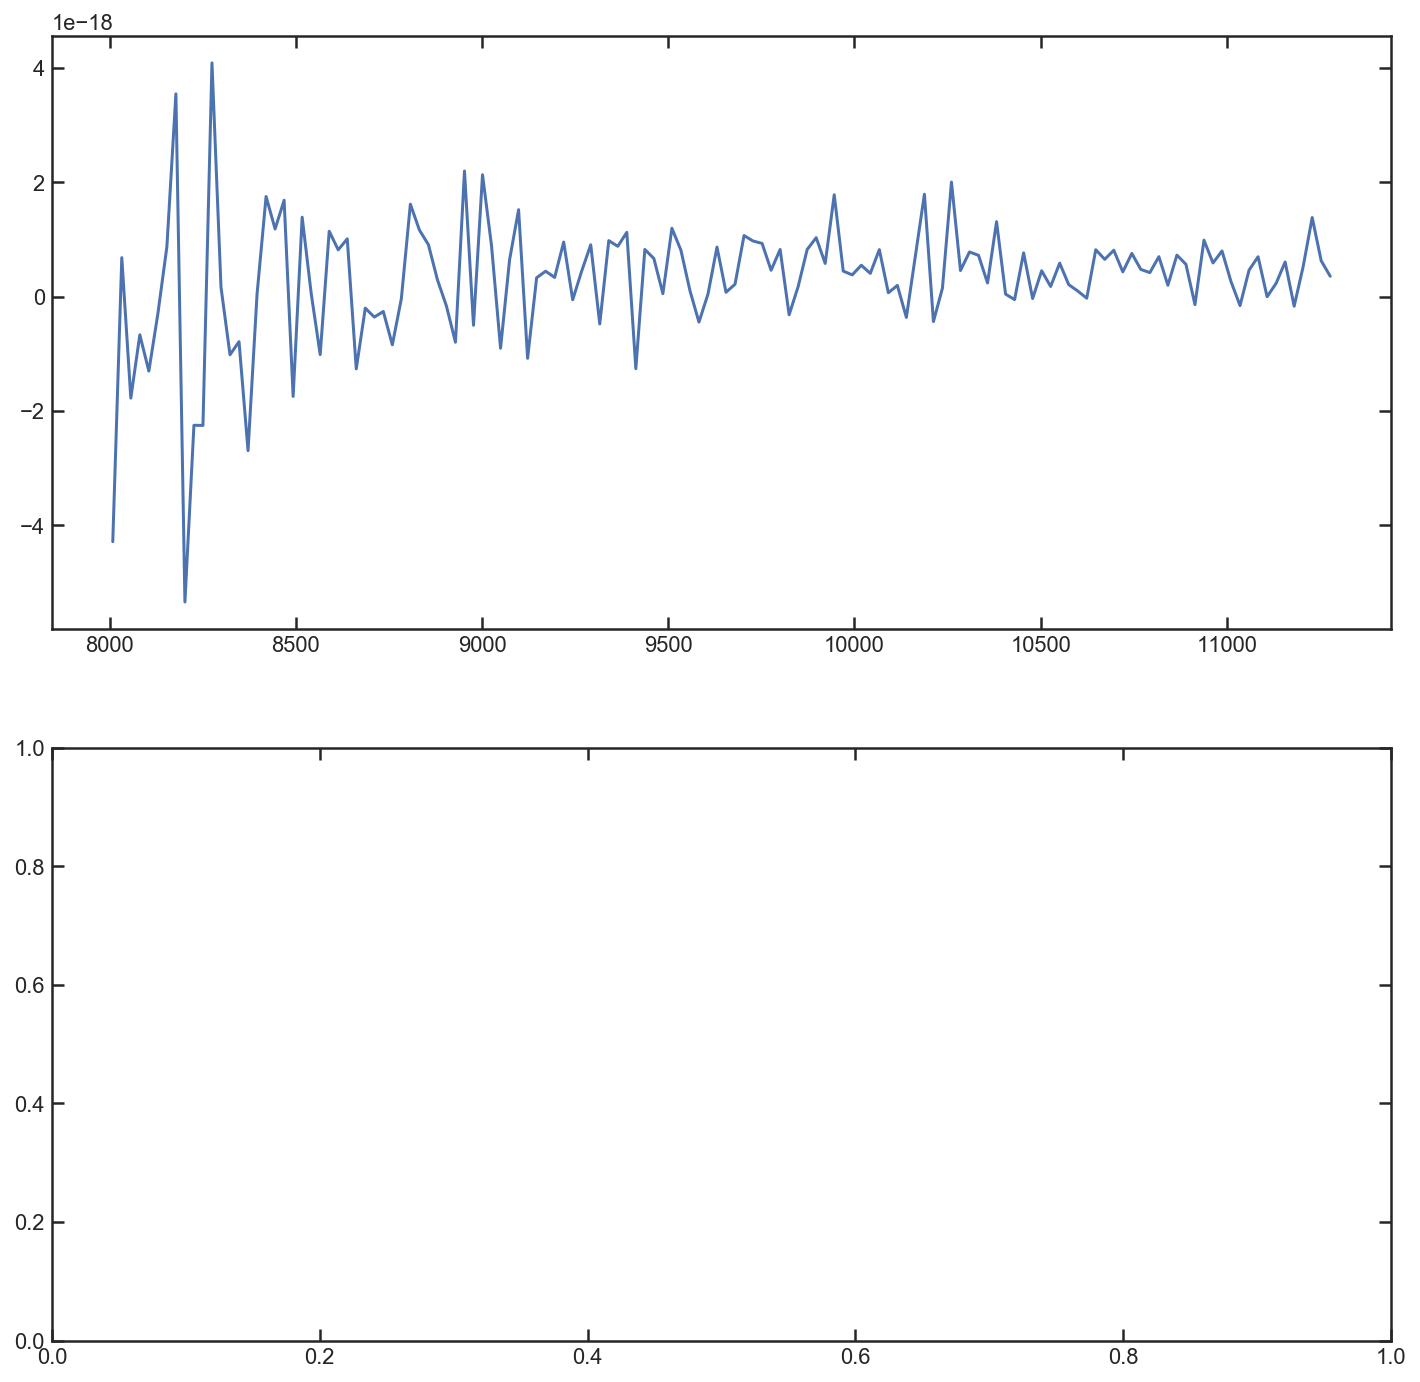

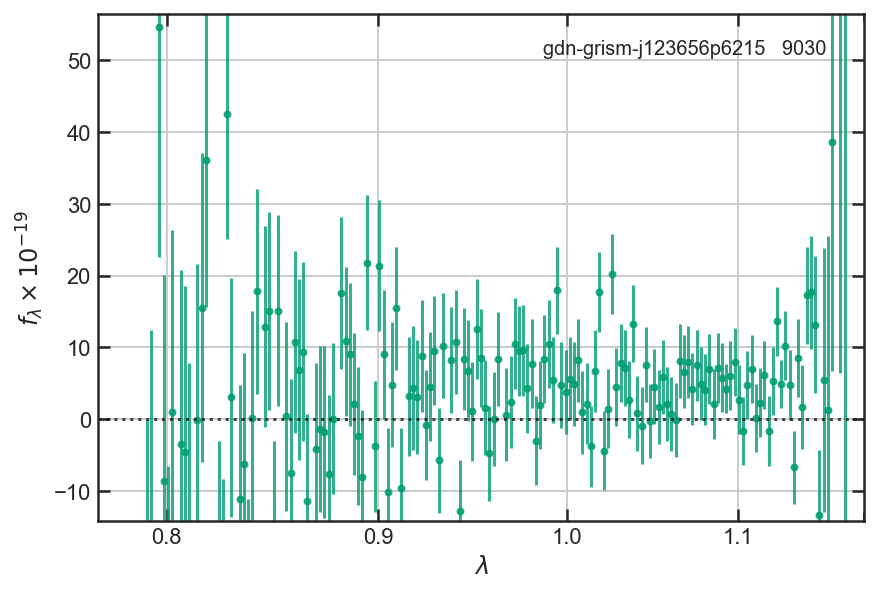

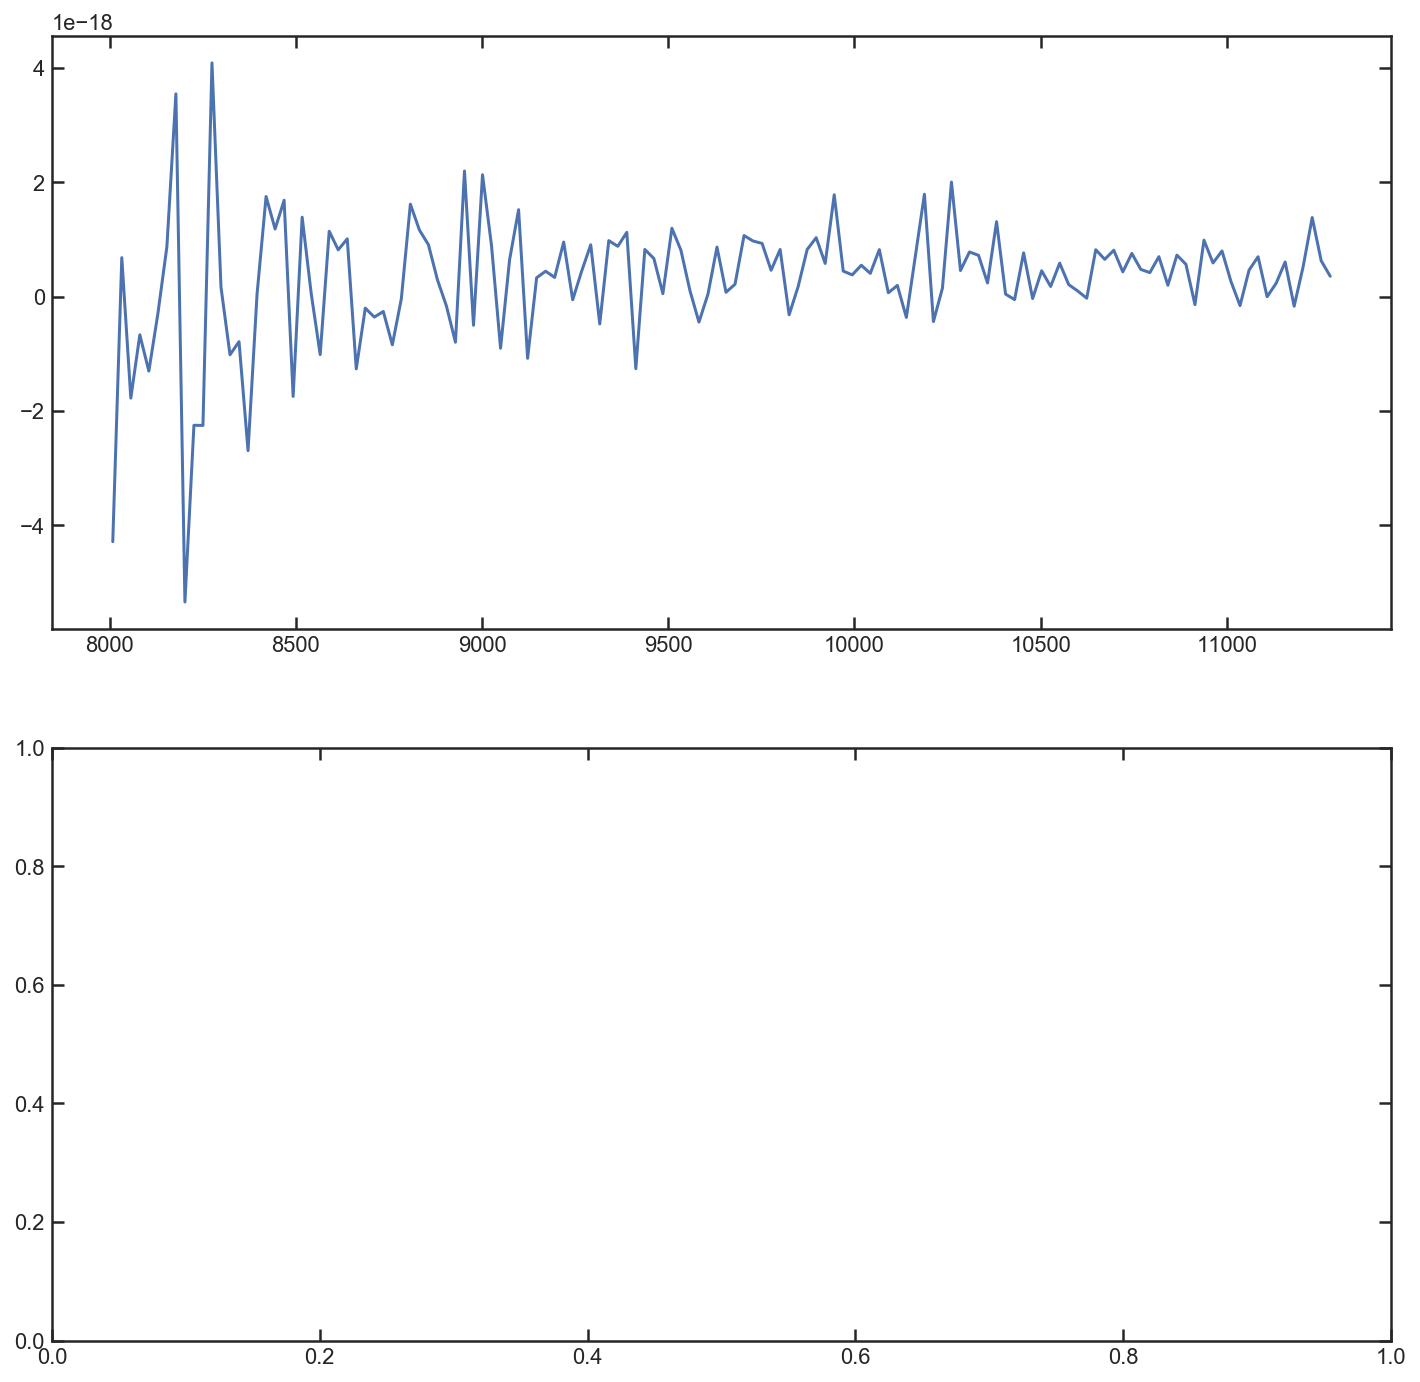

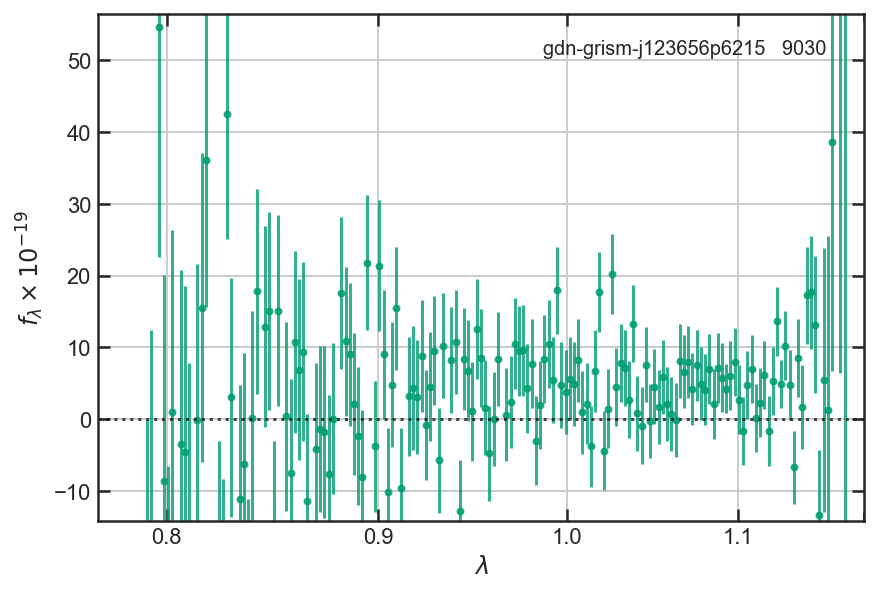

In [20]:
select = False
clip = False
omit = False

if clip or omit:
    select = True

gs = gridspec.GridSpec(2,1)

plt.figure(figsize=[12,12])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

BEAM_exempt =[]
ids = 0
omitspec = []
clipspec = []

for bm in mb.beams:
    xspec, yspec, yerr = bm.beam.optimal_extract(bm.grism.data['SCI'] - bm.contam,ivar = bm.ivar)

    flat_model = bm.flat_flam.reshape(bm.beam.sh_beam)
    xspecm, yspecm, yerrm = bm.beam.optimal_extract(flat_model)

    if bm.grism.filter == 'G102':
        IDX = [U for U in range(len(xspec)) if 8000 < xspec[U] < 11300]
        ax1.plot(xspec[IDX],yspec[IDX]/yspecm[IDX], color = 'b')
    else:
        IDX = [U for U in range(len(xspec)) if 11200 < xspec[U] < 16500]
        ax2.plot(xspec[IDX],yspec[IDX]/yspecm[IDX], color = 'r') 

        
        ### selection for bad beams
        
    if select:
        #condition of bad beams
        bex = False
        
        for i in range(len(xspec)):
#             if (bm.grism.filter == 'G102' and 11000< xspec[i] < 11300) and (yspec[i]/yspecm[i]) > 0.2E-17:
#                 bex = True
# #                 clipspec.append(0)
# #                 omitspec.append(1)        
#                 break

    
            if (bm.grism.filter == 'G141' and 13000< xspec[i] < 14000) and ((yspec[i]/yspecm[i]) > 2.5E-18):
                bex = True
#                 clipspec.append(0)
#                 omitspec.append(1)        
                break
                
#             if bm.grism.filter == 'G141':
#                 bex = True
#                 clipspec.append(1)
#                 omitspec.append(0)
#                 break
        if bex:
            BEAM_exempt.append(bm.grism.parent_file)

fig = mb.oned_figure(show_beams=False)

### set up selection settings
if clip and not omit:
    clipspec = np.ones(len(BEAM_exempt))
    omitspec = np.zeros(len(BEAM_exempt))
if omit and not clip:
    omitspec = np.ones(len(BEAM_exempt))
    clipspec = np.zeros(len(BEAM_exempt))
if omit and clip:
    pass
    ###selection tool TBD

### if beams are to be clipped

multclip = False
if clip:    
    Clims =[[13000, 13500]]
else:
    clip_lims = []
    clipspec = np.zeros(len(BEAM_exempt))

if multclip:
    pass
    ###selection tool TBD
else:
    clip_lims = [Clims for U in BEAM_exempt]

if clip:
    idc = 0
    for bm in mb.beams:
        if bm.grism.parent_file in BEAM_exempt:
            xspec, yspec, yerr = bm.beam.optimal_extract(bm.grism.data['SCI'] - bm.contam,ivar = bm.ivar) 
            for lms in clip_lims[idc]:
                if clipspec[idc] == 1:
                    for i in range(len(xspec)):
                        if lms[0] < xspec[i]< lms[1]:
                            bm.grism.data['SCI'].T[i] = np.zeros_like(bm.grism.data['SCI'].T[i])
                            bm.grism.data['ERR'].T[i] = np.ones_like(bm.grism.data['ERR'].T[i])*1000
            idc+=1 
print(BEAM_exempt)          
### if beams are to be omitted
if omit:
    ido = 0
    IDB = []
    for i in range(len(mb.beams)):
        if mb.beams[i].grism.parent_file in BEAM_exempt:
            if omitspec[ido] == 1:
                IDB.append(i) 
            ido += 1
                   
    BEAMS = []
    
    for i in range(len(mb.beams)):
        if i not in IDB:
            BEAMS.append(mb.beams[i])

else:
    BEAMS = mb.beams
    omitspec = np.zeros(len(BEAM_exempt))

### remake mb
mb = multifit.MultiBeam(BEAMS, **args)

gs = gridspec.GridSpec(2,1)

plt.figure(figsize=[12,12])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

for bm in mb.beams:
    xspec, yspec, yerr = bm.beam.optimal_extract(bm.grism.data['SCI'] - bm.contam,ivar = bm.ivar)

    flat_model = bm.flat_flam.reshape(bm.beam.sh_beam)
    xspecm, yspecm, yerrm = bm.beam.optimal_extract(flat_model)

    if bm.grism.filter == 'G102':
        IDX = [U for U in range(len(xspec)) if 8000 < xspec[U] < 11300]
        ax1.plot(xspec[IDX],yspec[IDX]/yspecm[IDX], color = 'b')
    else:
        IDX = [U for U in range(len(xspec)) if 11200 < xspec[U] < 16500]
        ax2.plot(xspec[IDX],yspec[IDX]/yspecm[IDX], color = 'r') 

fig = mb.oned_figure(show_beams=False)

print(BEAM_exempt)
print(clipspec,clip_lims)
print(omitspec)


# np.save('../beams/beam_config/{}_{}_ex'.format(alldb.field[idx], alldb.id[idx]),[BEAM_exempt])
# np.save('../beams/beam_config/{}_{}'.format(alldb.field[idx], alldb.id[idx]),[clip_lims,clipspec,omitspec])